In [1]:
#Getting acces to your google drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd 'drive/My Drive/ColabNotebooks/UNET/'

/content/drive/My Drive/ColabNotebooks/UNET


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Fun
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from PIL import Image
import numpy as np
import cv2 as cv
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.metrics import MeanIoU
import csv
import random
import json
from collections import defaultdict

from matplotlib import pyplot as plt
import pandas as pd

In [4]:
# UNET

class DoubleConv(nn.Module):
    """
    A double 3x3 same convolution followed by a Batch Normalization
    layer and a ReLU Activation function each.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    """
    U-Net Network Architecture as described in: https://arxiv.org/abs/1505.04597
    But making use of same convolutions and Batch Normalization.
    """
    def __init__(self, in_channels, n_classes, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path (down)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Expanding path (up)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Step size of 2 because ups contains a upsampling step follow by a double conv
        for idx in range(0, len(self.ups), 2):
            # Do the upsampling step
            x = self.ups[idx](x)
            feature_map = skip_connections[idx//2]

            if x.shape != feature_map.shape:
                x = TF.resize(x, size=feature_map.shape[2:])

            # Concatenate encoder and decoder feature maps from corresponding levels
            concat = torch.cat((feature_map, x), dim=1)
            # Do the double convolutions
            x = self.ups[idx+1](concat)

        return self.final_conv(x)

In [5]:
# Dataset

class SievesDataset(Dataset):
    def __init__(self, image_list, image_dir, mask_dir, transform=None):
        self.images = image_list
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        #Load image and corresponding mask
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Preprocess mask (for multiclass)
        mask[mask == 127.0] = 1
        mask[mask == 255.0] = 2

        #Data augmentation
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [6]:
# Utils

class MetricTracker:
    def __init__(self, n_classes):
        self.total_mean_iou = MeanIoU(num_classes=n_classes)

    def calculate_iou(self, preds, targets):
        with torch.no_grad():
            preds = torch.argmax(preds, dim=1)
            preds = preds.cpu().numpy()

            # Loop through an individual batch
            for pred, target in zip(preds, targets):
                target = target.cpu().numpy()
                # Update to the IoU over all images in the batch
                self.total_mean_iou.update_state(target, pred)

    def get(self):
        return self.total_mean_iou.result().numpy()


def save_checkpoint(state, folder, filename):
    print("=> Saving checkpoint")
    print(f"Filename = {filename}")
    model_path = os.path.join(folder, filename)
    torch.save(state, model_path)


def load_checkpoint(model, folder, filename):
    print("=> Loading checkpoint")
    print(f"Filename = {filename}")
    checkpoint_path = os.path.join(folder, filename)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])


def get_loader(
        image_list,
        image_dir,
        mask_dir,
        batch_size,
        transform,
        num_workers=2,
        pin_memory=True,
):
    # Create train dataset + specify the transforms / directories
    ds = SievesDataset(
        image_list,
        image_dir=image_dir,
        mask_dir=mask_dir,
        transform=transform,
    )

    # Create training loader + specify training dataset and parameters + shuffle order randomly
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    return loader


def compute_iou_per_class(mean_iou):
    # Matrix: Row = true labels | Columns = predicted labels
    # [0,0] = Number of pixels where, True label = 0 & Predicted label = 0
    # [0,1] = Number of pixels where, True label = 0 & Predicted label = 1
    pred_per_class = np.array(mean_iou.get_weights()[0])

    # IoU per class
    # Sum column and row 0 to get all the TP + FP + FN per class
    # Subtract the diagonal not to double count TP's
    sum_row = np.sum(pred_per_class, axis=1)
    sum_column = np.sum(pred_per_class, axis=0)
    # True Positives
    diagonal = np.diagonal(pred_per_class)
    # Union per class
    union_per_class = sum_row + sum_column - diagonal

    iou_per_class = diagonal/union_per_class

    return iou_per_class


def evaluate_model(loader, model, device="cuda"):
    n_classes = 3
    mean_iou = MeanIoU(num_classes=n_classes)

    # Evaluation mode
    model.eval()

    # Loop over batches
    for x, labels in loader:
        x = x.to(device)

        with torch.no_grad():
            preds = torch.argmax(model(x), dim=1)
            preds = preds.cpu().numpy()

            # Loop through an individual batch
            for pred, true_label in zip(preds, labels):
                true_label = true_label.cpu().numpy()
                # Update to the IoU over all images in the batch
                mean_iou.update_state(true_label, pred)

    iou_per_class = compute_iou_per_class(mean_iou)

    # Turn training mode back on
    model.train()

    return iou_per_class, mean_iou.result().numpy()


def save_predictions_as_imgs(
        loader, model, batch_size, folder, device="cuda"
):
    # Check if directory exist or create a new
    if not os.path.isdir(folder):
        os.mkdir(folder)

    # Evaluation mode
    model.eval()

    for idx_main, (x, labels), in enumerate(loader):
        x = x.to(device=device)

        with torch.no_grad():
            preds = torch.argmax(model(x), dim=1)
            preds = preds.cpu().numpy()

            # Save images in batch as individual images for inspection
            for idx_inner, (pred, true_label) in enumerate(zip(preds, labels)):
                # Calculate ongoing unique image number
                img_num = idx_main * batch_size + idx_inner

                # Turn categorical to grayscale values for easy inspection
                pred[pred == 1] = 127.0
                pred[pred == 2] = 255.0
                # Turn categorical to grayscale values for easy inspection
                true_label[true_label == 1] = 127.0
                true_label[true_label == 2] = 255.0

                # Save predicted segmentations
                cv.imwrite(f"{folder}/pred_{img_num}.png", pred)
                # Save corresponding true segmentations
                cv.imwrite(f"{folder}/true_{img_num}.png", true_label.numpy())

    # Turn training mode back on
    model.train()

def write_to_csv(csv_path, epoch=None, train_loss=None, train_miou=None,
                 val_miou=None, class_iou=None, create_header=False, test_set=False):
    # Write for test set evaluation
    if test_set:
        header = ["mean_iou", "iou_class1", "iou_class2", "iou_class3"]
        with open(csv_path, "w", encoding="UTF8", newline="") as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(header)
            writer.writerow([val_miou, class_iou[0], class_iou[1], class_iou[2]])

        return

    # Create new header for train / validation set
    if create_header:
        header = ["epoch", "train_loss", "train_miou", "val_miou", "val_iou_class1", "val_iou_class2", "val_iou_class3"]
        with open(csv_path, "w", encoding="UTF8", newline="") as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(header)

        return

    # Add data row to train / validation csv
    with open(csv_path, "a", encoding="UTF8", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([epoch, train_loss, train_miou, val_miou, class_iou[0], class_iou[1], class_iou[2]])

def save_splits(folder, train, val, test):
    for file, name in zip([train, val, test], ["train", "val", "test"]):
        with open(f"{folder}/{name}_split.json", "w") as f:
            json.dump(file, f, indent=2)

def plot_train_val(model_dir, model_name):
    # Plot training / validation metrics
    # Read in the data into a pandas dataframe
    df = pd.read_csv(f"{model_dir}{model_name}.csv")

    # Training loss
    plt.plot(df["epoch"], df["train_loss"])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Loss')
    plt.title("Training Loss per Epoch")
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.show()

    # Training mIoU
    plt.plot(df["epoch"], df["train_miou"])
    plt.plot(df["epoch"], df["val_miou"])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean IoU')
    plt.title("Mean IoU per Epoch")
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.legend(["Train", "Validation"])
    plt.show()

    # Validation Class IoU
    plt.plot(df["epoch"], df["val_iou_class1"], color="red")
    plt.plot(df["epoch"], df["val_iou_class2"], color="blue")
    plt.plot(df["epoch"], df["val_iou_class3"], color="green")
    plt.xlabel('Number of Epochs')
    plt.ylabel('Validation Class IoU')
    plt.title("Validation Class IoU per Epoch")
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.legend(["Class 1 (Background)", "Class 2 (Holes)", "Class 3 (Debris)"])
    plt.show()

In [7]:
# Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, predictions, targets):
        ce_loss = nn.functional.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        return torch.mean(focal_loss)

In [8]:
# Train

# Hyper parameters & settings
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 7
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 720
IMAGE_WIDTH = 720
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_DIR = "data/images/"
MASK_DIR = "data/masks/"
SAVED_IMAGES_DIR = "saved_images/"
MODEL_DIR = 'saved_models/'
MODEL_NAME = f'epochs{NUM_EPOCHS}_batch{BATCH_SIZE}_h{IMAGE_HEIGHT}_w{IMAGE_WIDTH}_lr{LEARNING_RATE}_RandomResizedCrops_focalloss'
N_CLASSES = 3
TRAIN_RATIO = 0.8               # 80%
VAL_RATIO = TRAIN_RATIO + 0.1   # 10% | Remaining % -> 10% is for the test set


def train_fn(loader, model, optimizer, loss_fn, scaler, epoch):
    loop = tqdm(loader)
    epoch_metrics = MetricTracker(N_CLASSES)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE).long()

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

            # Full epoch metrics: cumulative metrics of the batches
            epoch_metrics.calculate_iou(predictions, targets)

        # backwards
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_description(f"Epoch: {epoch}/{NUM_EPOCHS}")
        loop.set_postfix(loss=loss.item())

    return loss.item(), epoch_metrics.get()

In [9]:
# RUN

train_transform = A.Compose(
        [
            A.RandomResizedCrop(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, scale=(0.1, 1.0), p=1.0),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2()
        ]
    )

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ]
)

# Create train / val / test split randomly
all_images = os.listdir(IMAGE_DIR)
random.seed(42)
random.shuffle(all_images)
train_split, val_split, test_split = np.split(
    all_images,
    [int(TRAIN_RATIO*len(all_images)), int(VAL_RATIO*len(all_images))]
)

# Save splits for later evaluation -> especially the test split for this trained model
save_splits(MODEL_DIR, list(train_split), list(val_split), list(test_split))

train_loader = get_loader(train_split, IMAGE_DIR, MASK_DIR, BATCH_SIZE,
                            train_transform, NUM_WORKERS, PIN_MEMORY
                            )

val_loader = get_loader(val_split, IMAGE_DIR, MASK_DIR, BATCH_SIZE,
                        val_transform, NUM_WORKERS, PIN_MEMORY
                        )


print(f"Training for: {NUM_EPOCHS} epochs | Batchsize : {BATCH_SIZE} | WxH: {IMAGE_WIDTH}x{IMAGE_HEIGHT} | LR: {LEARNING_RATE} | Focal Loss")

model = UNET(in_channels=3, n_classes=N_CLASSES).to(DEVICE)
loss_fn = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Load model for further training
if LOAD_MODEL:
    load_checkpoint(model, f"model_map", f"model_name")

# Gradient scaling, inorder to prevent vanishing or exploding gradients
scaler = torch.cuda.amp.GradScaler()

# Dummy variable model performance comparison
# Holding the epoch & Mean_IoU of when the model performed best
best_mean_iou = (0, -1)

csv_path = os.path.join(MODEL_DIR, f"{MODEL_NAME}.csv")
write_to_csv(csv_path, create_header=True)

# Training Loop
for epoch in range(NUM_EPOCHS):
    # Train model and return the loss
    train_loss, train_miou = train_fn(train_loader, model, optimizer, loss_fn, scaler, epoch+1)

    # Save model
    checkpoint = {
        "state_dict" : model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    # Evaluate the current training epoch on the validation data
    val_class_iou, val_miou = evaluate_model(val_loader, model, device=DEVICE)
    write_to_csv(csv_path, epoch+1, train_loss, train_miou, val_miou, val_class_iou)

    print(f"Train mIoU: {train_miou} | Validation mIoU: {val_miou} | Validation Class IoU: {val_class_iou}")

    if val_miou > best_mean_iou[1]:
        print(f"New best validation mIoU: {val_miou} | Previous best mIoU: {best_mean_iou[1]} in epoch: {best_mean_iou[0]}.")
        # save_checkpoint(checkpoint, folder=f"saved_models/", filename=f"checkpoint_epoch{epoch+1}.pth.tar")
        # For now just overwrite previous best model
        save_checkpoint(checkpoint, folder=MODEL_DIR, filename=f"{MODEL_NAME}.pth.tar")

        # Save some examples to a folder for inspection
        save_predictions_as_imgs(
            val_loader, model, BATCH_SIZE, folder=f"{SAVED_IMAGES_DIR}/epoch{epoch+1}/", device=DEVICE
        )

        # Update best IoU
        best_mean_iou = (epoch+1, val_miou)

Training for: 50 epochs | Batchsize : 7 | WxH: 720x720 | LR: 0.0001 | Focal Loss


Epoch: 1/50: 100%|██████████| 81/81 [04:43<00:00,  3.50s/it, loss=0.0435]


Train mIoU: 0.562465488910675 | Validation mIoU: 0.4936048984527588 | Validation Class IoU: [0.88656527 0.5942495  0.        ]
New best validation mIoU: 0.4936048984527588 | Previous best mIoU: -1 in epoch: 0.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 2/50: 100%|██████████| 81/81 [01:53<00:00,  1.41s/it, loss=0.0346]


Train mIoU: 0.6069006323814392 | Validation mIoU: 0.6010706424713135 | Validation Class IoU: [0.9506334 0.8525785 0.       ]
New best validation mIoU: 0.6010706424713135 | Previous best mIoU: 0.4936048984527588 in epoch: 1.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 3/50: 100%|██████████| 81/81 [01:55<00:00,  1.43s/it, loss=0.0404]


Train mIoU: 0.6277496218681335 | Validation mIoU: 0.6103721261024475 | Validation Class IoU: [0.95649606 0.8732686  0.00135184]
New best validation mIoU: 0.6103721261024475 | Previous best mIoU: 0.6010706424713135 in epoch: 2.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 4/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0271]


Train mIoU: 0.6922886967658997 | Validation mIoU: 0.6122580170631409 | Validation Class IoU: [0.95139897 0.8555864  0.02978874]
New best validation mIoU: 0.6122580170631409 | Previous best mIoU: 0.6103721261024475 in epoch: 3.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 5/50: 100%|██████████| 81/81 [01:55<00:00,  1.43s/it, loss=0.0431]


Train mIoU: 0.7229545712471008 | Validation mIoU: 0.630319356918335 | Validation Class IoU: [0.9595867  0.87771064 0.05366078]
New best validation mIoU: 0.630319356918335 | Previous best mIoU: 0.6122580170631409 in epoch: 4.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 6/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0562]


Train mIoU: 0.741339385509491 | Validation mIoU: 0.6643577218055725 | Validation Class IoU: [0.9663739  0.9015312  0.12516801]
New best validation mIoU: 0.6643577218055725 | Previous best mIoU: 0.630319356918335 in epoch: 5.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 7/50: 100%|██████████| 81/81 [01:56<00:00,  1.43s/it, loss=0.032]


Train mIoU: 0.7324516177177429 | Validation mIoU: 0.6498115658760071 | Validation Class IoU: [0.961079   0.88063294 0.10772277]


Epoch: 8/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0187]


Train mIoU: 0.7547377943992615 | Validation mIoU: 0.6185943484306335 | Validation Class IoU: [0.95421153 0.8608797  0.04069187]


Epoch: 9/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0138]


Train mIoU: 0.7485536932945251 | Validation mIoU: 0.5652250051498413 | Validation Class IoU: [0.9210402  0.7260957  0.04853918]


Epoch: 10/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.00949]


Train mIoU: 0.7539739608764648 | Validation mIoU: 0.6752073168754578 | Validation Class IoU: [0.9712762  0.91729623 0.13704948]
New best validation mIoU: 0.6752073168754578 | Previous best mIoU: 0.6643577218055725 in epoch: 6.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 11/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.022]


Train mIoU: 0.7684710621833801 | Validation mIoU: 0.7170557379722595 | Validation Class IoU: [0.9718767 0.9150237 0.2642668]
New best validation mIoU: 0.7170557379722595 | Previous best mIoU: 0.6752073168754578 in epoch: 10.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 12/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0139]


Train mIoU: 0.7343639731407166 | Validation mIoU: 0.6618087887763977 | Validation Class IoU: [0.9684169  0.90876395 0.10824563]


Epoch: 13/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0156]


Train mIoU: 0.769160807132721 | Validation mIoU: 0.7775883078575134 | Validation Class IoU: [0.97265375 0.917122   0.44298902]
New best validation mIoU: 0.7775883078575134 | Previous best mIoU: 0.7170557379722595 in epoch: 11.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 14/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0219]


Train mIoU: 0.7830421924591064 | Validation mIoU: 0.7726117968559265 | Validation Class IoU: [0.9697292 0.9063823 0.4417238]


Epoch: 15/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0508]


Train mIoU: 0.7716458439826965 | Validation mIoU: 0.7095308899879456 | Validation Class IoU: [0.95728135 0.8755295  0.29578176]


Epoch: 16/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0332]


Train mIoU: 0.786273717880249 | Validation mIoU: 0.7780805230140686 | Validation Class IoU: [0.97274536 0.9173185  0.44417775]
New best validation mIoU: 0.7780805230140686 | Previous best mIoU: 0.7775883078575134 in epoch: 13.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 17/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0169]


Train mIoU: 0.7963697910308838 | Validation mIoU: 0.6851933002471924 | Validation Class IoU: [0.9712092 0.9168739 0.1674967]


Epoch: 18/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0173]


Train mIoU: 0.7999566197395325 | Validation mIoU: 0.7388460636138916 | Validation Class IoU: [0.97318125 0.9202669  0.32309008]


Epoch: 19/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0084]


Train mIoU: 0.7973630428314209 | Validation mIoU: 0.6215622425079346 | Validation Class IoU: [0.9570621  0.86663216 0.04099255]


Epoch: 20/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0265]


Train mIoU: 0.7840517163276672 | Validation mIoU: 0.7419614791870117 | Validation Class IoU: [0.97558886 0.9296609  0.32063454]


Epoch: 21/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0163]


Train mIoU: 0.8103378415107727 | Validation mIoU: 0.7456295490264893 | Validation Class IoU: [0.972938   0.9177843  0.34616643]


Epoch: 22/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.017]


Train mIoU: 0.8151080012321472 | Validation mIoU: 0.741018533706665 | Validation Class IoU: [0.9762607  0.93211687 0.31467804]


Epoch: 23/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0225]


Train mIoU: 0.8102633953094482 | Validation mIoU: 0.6032460927963257 | Validation Class IoU: [0.9220626  0.72677773 0.16089796]


Epoch: 24/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0202]


Train mIoU: 0.7963671684265137 | Validation mIoU: 0.6957452297210693 | Validation Class IoU: [0.9648299  0.89122313 0.23118259]


Epoch: 25/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0165]


Train mIoU: 0.7897400259971619 | Validation mIoU: 0.7369067668914795 | Validation Class IoU: [0.975182  0.9277555 0.3077828]


Epoch: 26/50: 100%|██████████| 81/81 [01:58<00:00,  1.46s/it, loss=0.0171]


Train mIoU: 0.7990686893463135 | Validation mIoU: 0.7652963995933533 | Validation Class IoU: [0.97590834 0.9254893  0.3944915 ]


Epoch: 27/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0145]


Train mIoU: 0.7882733345031738 | Validation mIoU: 0.7810352444648743 | Validation Class IoU: [0.972279  0.9138686 0.4569582]
New best validation mIoU: 0.7810352444648743 | Previous best mIoU: 0.7780805230140686 in epoch: 16.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 28/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0135]


Train mIoU: 0.8271738886833191 | Validation mIoU: 0.8368406891822815 | Validation Class IoU: [0.98122126 0.9429131  0.5863878 ]
New best validation mIoU: 0.8368406891822815 | Previous best mIoU: 0.7810352444648743 in epoch: 27.
=> Saving checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar


Epoch: 29/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.00928]


Train mIoU: 0.8161318898200989 | Validation mIoU: 0.7872835993766785 | Validation Class IoU: [0.9778427 0.9339627 0.4500453]


Epoch: 30/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0142]


Train mIoU: 0.8042044043540955 | Validation mIoU: 0.7086114883422852 | Validation Class IoU: [0.97177917 0.9167888  0.23726656]


Epoch: 31/50: 100%|██████████| 81/81 [01:57<00:00,  1.44s/it, loss=0.0165]


Train mIoU: 0.8113989233970642 | Validation mIoU: 0.6610406041145325 | Validation Class IoU: [0.95948464 0.8739816  0.14965543]


Epoch: 32/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0137]


Train mIoU: 0.8293234705924988 | Validation mIoU: 0.7017138600349426 | Validation Class IoU: [0.9764754  0.93411607 0.19455023]


Epoch: 33/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0217]


Train mIoU: 0.8064181208610535 | Validation mIoU: 0.7617742419242859 | Validation Class IoU: [0.9742641  0.92216253 0.388896  ]


Epoch: 34/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.00875]


Train mIoU: 0.8060553073883057 | Validation mIoU: 0.7866474986076355 | Validation Class IoU: [0.9775334  0.9331602  0.44924888]


Epoch: 35/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0127]


Train mIoU: 0.8166272640228271 | Validation mIoU: 0.8208392262458801 | Validation Class IoU: [0.9775289  0.93198824 0.5530006 ]


Epoch: 36/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0112]


Train mIoU: 0.8365814685821533 | Validation mIoU: 0.7982193827629089 | Validation Class IoU: [0.9791357  0.93840116 0.47712126]


Epoch: 37/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0133]


Train mIoU: 0.8207420706748962 | Validation mIoU: 0.7965635657310486 | Validation Class IoU: [0.9751878  0.92407477 0.490428  ]


Epoch: 38/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0108]


Train mIoU: 0.8164986968040466 | Validation mIoU: 0.7227718830108643 | Validation Class IoU: [0.9608957  0.8736615  0.33375844]


Epoch: 39/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0106]


Train mIoU: 0.818662703037262 | Validation mIoU: 0.7183660864830017 | Validation Class IoU: [0.9733231  0.9216542  0.26012084]


Epoch: 40/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0261]


Train mIoU: 0.8158580660820007 | Validation mIoU: 0.810296356678009 | Validation Class IoU: [0.9777183  0.9320117  0.52115923]


Epoch: 41/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0115]


Train mIoU: 0.815185546875 | Validation mIoU: 0.8268599510192871 | Validation Class IoU: [0.9744593  0.92074126 0.58537936]


Epoch: 42/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0149]


Train mIoU: 0.8125970959663391 | Validation mIoU: 0.7896153330802917 | Validation Class IoU: [0.97677726 0.9303297  0.4617391 ]


Epoch: 43/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.0545]


Train mIoU: 0.8177269101142883 | Validation mIoU: 0.7427701950073242 | Validation Class IoU: [0.9768068  0.9336279  0.31787577]


Epoch: 44/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0106]


Train mIoU: 0.7985391020774841 | Validation mIoU: 0.713823139667511 | Validation Class IoU: [0.9677342  0.90334773 0.27038756]


Epoch: 45/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0143]


Train mIoU: 0.8263614773750305 | Validation mIoU: 0.7923632264137268 | Validation Class IoU: [0.97368354 0.9186858  0.48472038]


Epoch: 46/50: 100%|██████████| 81/81 [01:57<00:00,  1.44s/it, loss=0.0121]


Train mIoU: 0.8020514845848083 | Validation mIoU: 0.7907310128211975 | Validation Class IoU: [0.9762483  0.9283156  0.46762913]


Epoch: 47/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.014]


Train mIoU: 0.7995357513427734 | Validation mIoU: 0.6853781342506409 | Validation Class IoU: [0.971412   0.9184198  0.16630267]


Epoch: 48/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0172]


Train mIoU: 0.8059349656105042 | Validation mIoU: 0.7173604965209961 | Validation Class IoU: [0.97414666 0.92452866 0.2534061 ]


Epoch: 49/50: 100%|██████████| 81/81 [01:56<00:00,  1.44s/it, loss=0.0141]


Train mIoU: 0.8335068225860596 | Validation mIoU: 0.7802742123603821 | Validation Class IoU: [0.97697186 0.9313958  0.43245494]


Epoch: 50/50: 100%|██████████| 81/81 [01:57<00:00,  1.45s/it, loss=0.00951]


Train mIoU: 0.8307578563690186 | Validation mIoU: 0.7152113914489746 | Validation Class IoU: [0.97421616 0.9251979  0.24622002]


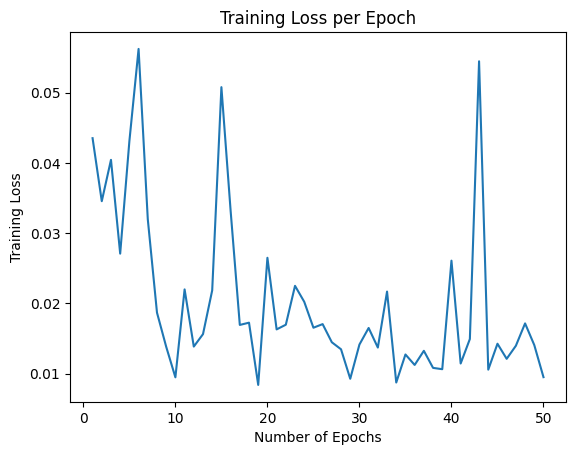

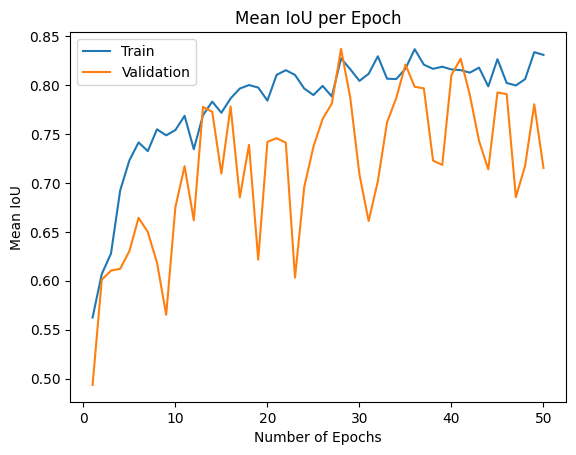

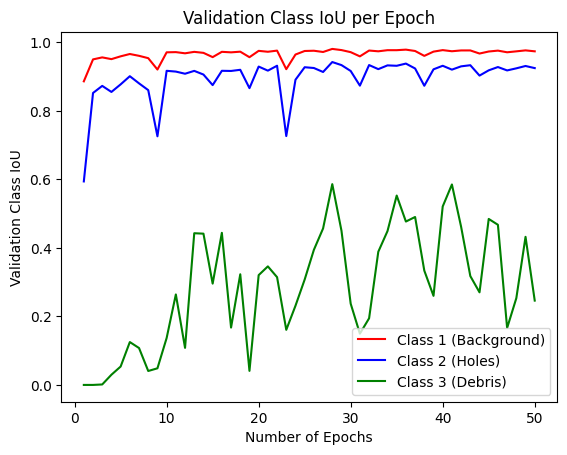

In [10]:
# Plot training / validation metrics

plot_train_val(MODEL_DIR, MODEL_NAME)

In [11]:
# Evaluate on the Test set

TEST_DIR = "saved_models/eval_test/"
# Change to load another model
# MODEL_NAME = "model_name"
# Change to save read from another data split
FILE_NAME = "test_split.json"

# Trying with transform first
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ]
)

# Retrieve test split for this model
with open(f"{MODEL_DIR}{FILE_NAME}") as f:
    test_json = f.read()
# Create split list
test_split = json.loads(test_json)

# Load trained model
model = UNET(in_channels=3, n_classes=N_CLASSES).to(DEVICE)
load_checkpoint(model, MODEL_DIR, f"{MODEL_NAME}.pth.tar")

# Create test ds + loader
test_loader = get_loader(test_split, IMAGE_DIR, MASK_DIR, BATCH_SIZE,
                        val_transform, NUM_WORKERS, PIN_MEMORY)

# Evaluate mIoU and class IoU
class_iou, miou = evaluate_model(test_loader, model, device=DEVICE)
print(f"----------------------------------------------------------------------------------------------------------------")
print(f"Evaluating model on the test set | mIoU: {miou}")
print(f"IoU class 1 (background): {class_iou[0]} | IoU class 2 (holes): {class_iou[1]} | IoU class 3 (debris): {class_iou[2]}")
print(f"----------------------------------------------------------------------------------------------------------------")

# Save metrics
csv_path = os.path.join(TEST_DIR, f"{MODEL_NAME}.csv")
write_to_csv(csv_path, val_miou=miou, class_iou=class_iou, test_set=True)

# Save predictions and masks for inspection
save_predictions_as_imgs(
    test_loader, model, BATCH_SIZE, folder=f"{TEST_DIR}/examples/", device=DEVICE
)

=> Loading checkpoint
Filename = epochs50_batch7_h720_w720_lr0.0001_RandomResizedCrops_focalloss.pth.tar
----------------------------------------------------------------------------------------------------------------
Evaluating model on the test set | mIoU: 0.8279383778572083
IoU class 1 (background): 0.9804202318191528 | IoU class 2 (holes): 0.9430571794509888 | IoU class 3 (debris): 0.5603377819061279
----------------------------------------------------------------------------------------------------------------


In [ ]:
# Close runtime to save valuable compute hours
from google.colab import runtime
runtime.unassign()